In [1]:
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses
from pycm import *
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_excel("dataset.xlsx", sheet_name=None, header=0)

In [3]:
all_df = {}
for i, d in enumerate(df.items()):
    name, data = d
    all_df[name] = data
all_data = pd.concat(df.values())

In [4]:
all_data = all_data[[ "DEPTH", "DT", "GR", "LLD", "NPHI", "RHOB", "Log_Facies", "Fluid"]]
all_data = all_data.dropna(axis=0, how='any')
data = all_data

In [5]:
data = data[data['DEPTH'] == data["DEPTH"]]   # drop NaN value row

In [6]:
data['Log_Facies'] = data['Log_Facies'].apply(lambda x: int(x))

In [7]:
comb = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
def label_facies(row):
    f = row['Fluid']
    lf = row['Log_Facies']
    return comb.index((f, lf)) + 1
data['MixLabel'] = data.apply(label_facies, axis=1)

In [8]:
data.shape

(4695, 9)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

In [10]:
X = data[["DEPTH", "DT", "GR", "LLD", "NPHI", "RHOB",]]
ss = StandardScaler()
X = ss.fit_transform(X)

In [11]:
Y1 = data['Log_Facies'].values
Y2 = data['Fluid'].values
Y3 = data['MixLabel'].values
Y_Label = ['Log_Facies', 'Fluid', 'MixLabel']

In [12]:
num_of_shuffler = 10
shuffler1 = StratifiedShuffleSplit(n_splits=num_of_shuffler, test_size=0.1).split(X, Y1)
shuffler2 = StratifiedShuffleSplit(n_splits=num_of_shuffler, test_size=0.1).split(X, Y2)
shuffler3 = StratifiedShuffleSplit(n_splits=num_of_shuffler, test_size=0.1).split(X, Y3)

In [13]:
s1 = [x for x in shuffler1]
s2 = [x for x in shuffler2]
s3 = [x for x in shuffler3]

In [14]:
indices1 = [(train_idx, validation_idx) for train_idx, validation_idx in s1]
indices2 = [(train_idx, validation_idx) for train_idx, validation_idx in s2]
indices3 = [(train_idx, validation_idx) for train_idx, validation_idx in s3]

In [15]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        return self.fc2(x)

input_size = 6
num_classes = 2
hidden_size = 15
epochs = 100
lr = 0.01
batch_size = 64
test_batch_size = 1000
momentum = 0.1

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

X = torch.Tensor(X)
Y = Y2-1
Y = torch.Tensor(Y)


In [16]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
Y = Y.long()

In [17]:
X_train, Y_train = X[indices[0]], Y[indices[0]]
X_val, Y_val = X[indices[1]], Y[indices[1]]
data_train = TensorDataset(X_train, Y_train)
data_val = TensorDataset(X_val, Y_val)

In [18]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X)
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(data_val, batch_size=test_batch_size, shuffle=False, num_workers=0)
#test_loader = DataLoader(data_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

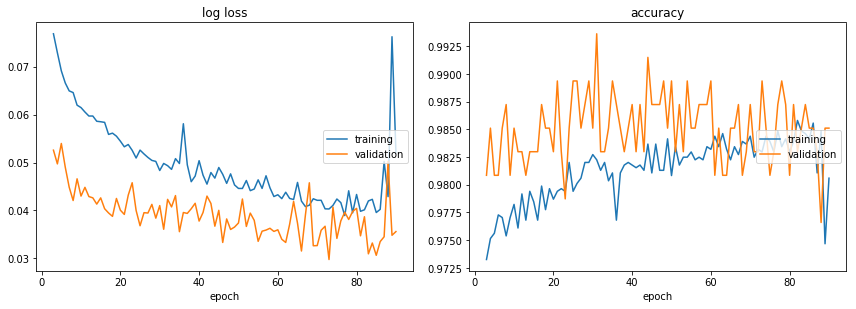

log loss:
training   (min:    0.039, max:    0.296, cur:    0.052)
validation (min:    0.030, max:    0.085, cur:    0.036)

accuracy:
training   (min:    0.882, max:    0.986, cur:    0.981)
validation (min:    0.972, max:    0.994, cur:    0.985)


In [19]:
device = 'cpu'
liveloss = PlotLosses()
for epoch in range(90):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()

In [20]:
input_size = 6
num_classes = 3
hidden_size = 15
epochs = 100
lr = 0.01
batch_size = 64
test_batch_size = 1000
momentum = 0.1

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

X = torch.Tensor(X)
Y = Y1-1
Y = torch.Tensor(Y)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
Y = Y.long()

X_train, Y_train = X[indices[0]], Y[indices[0]]
X_val, Y_val = X[indices[1]], Y[indices[1]]
data_train = TensorDataset(X_train, Y_train)
data_val = TensorDataset(X_val, Y_val)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(data_val, batch_size=test_batch_size, shuffle=False, num_workers=0)

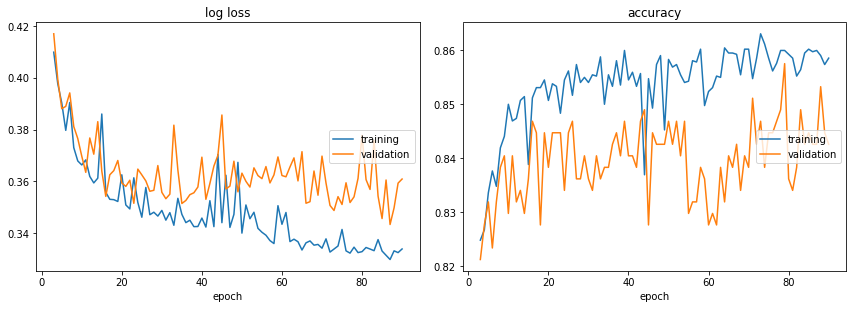

log loss:
training   (min:    0.330, max:    0.647, cur:    0.334)
validation (min:    0.343, max:    0.485, cur:    0.361)

accuracy:
training   (min:    0.709, max:    0.863, cur:    0.858)
validation (min:    0.787, max:    0.857, cur:    0.843)


In [21]:
device = 'cpu'
liveloss = PlotLosses()
for epoch in range(90):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()

In [22]:
input_size = 6
num_classes = 5
hidden_size = 15
epochs = 100
lr = 0.01
batch_size = 64
test_batch_size = 1000
momentum = 0.1

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

X = torch.Tensor(X)
Y = Y3-1
Y = torch.Tensor(Y)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
Y = Y.long()

X_train, Y_train = X[indices[0]], Y[indices[0]]
X_val, Y_val = X[indices[1]], Y[indices[1]]
data_train = TensorDataset(X_train, Y_train)
data_val = TensorDataset(X_val, Y_val)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(data_val, batch_size=test_batch_size, shuffle=False, num_workers=0)


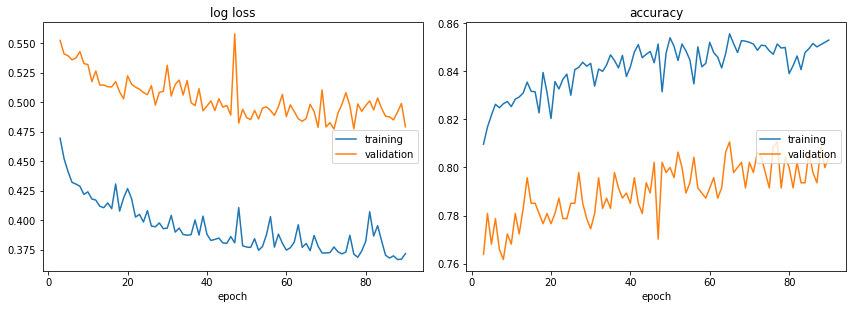

log loss:
training   (min:    0.367, max:    0.997, cur:    0.372)
validation (min:    0.477, max:    0.705, cur:    0.479)

accuracy:
training   (min:    0.595, max:    0.856, cur:    0.853)
validation (min:    0.730, max:    0.811, cur:    0.804)


In [23]:
device = 'cpu'
liveloss = PlotLosses()
for epoch in range(90):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()